<a href="https://colab.research.google.com/github/minaraaz/MachineLearningCourse/blob/master/HW3/HW3_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2

This Colab Notebook is the solution of the problem 2. In this notebook I have used VGG19 pretrained network on imagenet to train the cats and dog dataset and fine tuned my network with its weights.

In [0]:
import os
from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import tensorflow as tf
from keras.layers import Dense, Activation, Flatten, Dropout

# Preprocessing dataset

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-16 19:10:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.129.128, 2607:f8b0:4001:c1d::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.129.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   112MB/s    in 0.6s    

2019-04-16 19:10:53 (112 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Creating CNN using VGG19

In [0]:
# Convnet
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten(name='flatten')(conv_base.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dense(2, activation='softmax', name='predictions')(x)

# stitch together
model = models.Model(inputs= conv_base.input, outputs=x)

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=20, class_mode='categorical')
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(224, 224), batch_size=20, class_mode='categorical')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# Fine Tuning
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
# compile model
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

# train
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=50,validation_data=validation_generator, validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
100/100 [==============================] - 39s 388ms/step - loss: 0.7494 - acc: 0.5520 - val_loss: 0.5705 - val_acc: 0.7180
Epoch 2/50
100/100 [==============================] - 32s 322ms/step - loss: 0.6492 - acc: 0.6450 - val_loss: 0.5329 - val_acc: 0.7210
Epoch 3/50
100/100 [==============================] - 34s 337ms/step - loss: 0.5638 - acc: 0.6980 - val_loss: 0.4881 - val_acc: 0.7630
Epoch 4/50
100/100 [==============================] - 32s 323ms/step - loss: 0.5238 - acc: 0.7420 - val_loss: 0.3875 - val_acc: 0.8310
Epoch 5/50
100/100 [==============================] - 34s 336ms/step - loss: 0.4752 - acc: 0.7650 - val_loss: 0.3315 - val_acc: 0.8590
Epoch 6/50
100/100 [==============================] - 32s 325ms/step - loss: 0.4501 - acc: 0.7875 - val_loss: 0.2961 - val_acc: 0.8730
Epoch 7/50
100/100 [==============================] - 32s 325ms/step - loss: 0.4048 - acc: 0.8105 - val_loss: 0.2711 - val_acc: 0.8930
Epoch 8

# Visualization

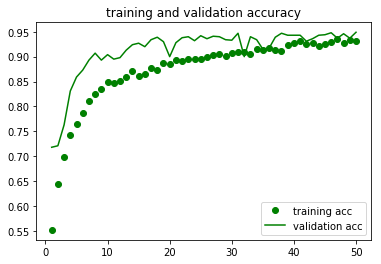

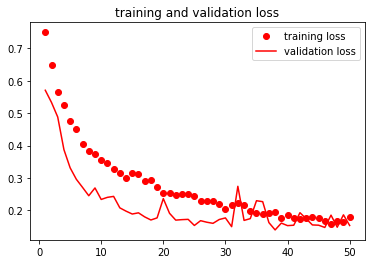

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'go', label='training acc')
plt.plot(epochs, val_acc, 'g', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'ro', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

# Evaluating the model
From the result we can see that accuracy has been improved comparing to the last model(without fine tuning).

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

('Validation loss:', 0.16169318202417343)
('Validation accuracy:', 0.9479999911785125)


# Saving the model
I saved the model to my google drive (it was too big to upload on github).

In [0]:
model_fname = 'VGG19-Finetuned-Cats_and_Dogs.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)